In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import sys
#sys.path.insert(0, '/Users/ammar.tareen/Desktop/Research_projects/mavenn2/')
sys.path.insert(0, '/Users/tareen/Desktop/Research_Projects/2022_mavenn2_github/mavenn')

import mavenn
import logomaker
import seaborn as sns
import re

%matplotlib inline

In [2]:
# # Load example data
# data_df = mavenn.load_example_dataset('sortseq')

# # Separate test from data_df
# ix_test = data_df['set']=='test'
# test_df = data_df[ix_test].reset_index(drop=True)
# print(f'test N: {len(test_df):,}')

# # Remove test data from data_df
# data_df = data_df[~ix_test].reset_index(drop=True)
# print(f'training + validation N: {len(data_df):,}')
# data_df.head()
#pd.read_csv
data_df_full = pd.read_csv('../data/2022.05.15.ace2rbd/ace2rbd_raw_counts_lib1.csv')
data_df = data_df_full[['x','SortSeq_bin1','SortSeq_bin2','SortSeq_bin3','SortSeq_bin4']].copy()
data_df.head(10)

,x,SortSeq_bin1,SortSeq_bin2,SortSeq_bin3,SortSeq_bin4
0,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,0,0
1,NITNLCPFGEVFSATRFASVYAWNRKRISNCVADYSVLYNSASFST...,116,92,21,3
2,NITNLCPFGEVFNATRFASVYCWNRKRISNCVADYSVLYNSASFST...,158,120,137,15
3,NITNLCPFGEVFFATRFASVYAWNRKRISNCVADYSVLYNSASFST...,47,234,521,116
4,NITNLKPFGEVFNAWRFASVYAWNRKRISNCVADYSVLYNSASFST...,299,32,1,1
5,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,322,238,196,14
6,NITNLCPFGEVFNATRFVSVYAWNRKRISNCVADYSVLYNSASFST...,38,78,181,45
7,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,1364,24,43,15
8,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,64,129,122,27
9,NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...,0,0,6,22


In [3]:
y_cols = data_df.columns[1:]

X = data_df['x']
y = data_df[y_cols]

In [4]:
from sklearn.model_selection import train_test_split

# split data into training and testing sets
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.1)

In [5]:
# set positional argumnets for gpmap function
L = len(data_df['x'][0])
alphabet_star=['A', 'C', 'D', 'E', 'F',
              'G', 'H', 'I', 'K', 'L',
              'M', 'N', 'P', 'Q', 'R',
              'S', 'T', 'V', 'W', 'Y','*']

alphabet=['A', 'C', 'D', 'E', 'F',
          'G', 'H', 'I', 'K', 'L',
          'M', 'N', 'P', 'Q', 'R',
          'S', 'T', 'V', 'W', 'Y']


Y = len(y_cols)
print(f'L={L}, Y={Y}')

L=201, Y=4


In [6]:
# instantiate gpmap object
gpmap = mavenn.gpmap.AdditiveGPMapLayer(L, alphabet)


2022-10-02 18:39:18.768471: I tensorflow/core/platform/cpu_feature_guard.cc:151] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


### Create measurement process object(s)

In [7]:
# I think this shouldn't require any positional arguments.
# mp_GE = mavenn.measurement_process_layers.GlobalEpistasisLayer(K=50,
#                                                                eta=1e-5,
#                                                                monotonic=True)
mp_mpa = mavenn.measurement_process_layers.DiscreteAgnosticMP(info_for_layers_dict={'H_y_norm':0},
                                                                      Y=Y,
                                                                      K=50,
                                                                      eta=1e-5,)


In [8]:
model = mavenn.Model2(gpmap=gpmap,
                      mp_list=[mp_mpa])

In [9]:
model.model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 Sequence_labels_input (InputLa  [(None, 4024)]      0           []                               
 yer)                                                                                             
                                                                                                  
 Sequence_only (Lambda)         (None, 4020)         0           ['Sequence_labels_input[0][0]']  
                                                                                                  
 additive_gp_map_layer (Additiv  (None, 1)           4021        ['Sequence_only[0][0]']          
 eGPMapLayer)                                                                                     
                                                                                              

In [10]:
# Set training data
model.set_data(x=x_train.values,
               y_list=[y_train.values],
               #validation_flags=(data_df['set']=='validation'),
               shuffle=True)


N = 83,880 observations set as training data.
Using 20.1% for validation.
Data shuffled.
Time to set data: 15.8 sec.


In [11]:

# Fit model to data
model.fit(learning_rate=.0005,
          epochs=150,
          batch_size=300,
          try_tqdm = False,
          early_stopping=True,
          early_stopping_patience=10,
          linear_initialization=False)

Epoch 1/150
224/224 [==============================] - 4s 11ms/step - loss: 218648.8594 - I_var: -0.0032 - val_loss: 219800.9688 - val_I_var: -0.0063
Epoch 2/150
224/224 [==============================] - 2s 9ms/step - loss: 218297.0000 - I_var: 6.7293e-05 - val_loss: 219717.6406 - val_I_var: -0.0055
Epoch 3/150
224/224 [==============================] - 2s 10ms/step - loss: 218254.5312 - I_var: -1.2658e-04 - val_loss: 219701.0156 - val_I_var: -0.0054
Epoch 4/150
224/224 [==============================] - 2s 8ms/step - loss: 218349.2344 - I_var: -2.7349e-04 - val_loss: 219744.1562 - val_I_var: -0.0058
Epoch 5/150
224/224 [==============================] - 2s 9ms/step - loss: 217036.4062 - I_var: 0.0103 - val_loss: 217688.3125 - val_I_var: 0.0117
Epoch 6/150
224/224 [==============================] - 5s 21ms/step - loss: 211842.9062 - I_var: 0.0557 - val_loss: 212330.6875 - val_I_var: 0.0578
Epoch 7/150
224/224 [==============================] - 3s 13ms/step - loss: 206863.2031 - I_var:

224/224 [==============================] - 2s 7ms/step - loss: 189234.5156 - I_var: 0.2499 - val_loss: 193717.6094 - val_I_var: 0.2166
Epoch 57/150
224/224 [==============================] - 2s 8ms/step - loss: 189018.5938 - I_var: 0.2516 - val_loss: 193466.4531 - val_I_var: 0.2187
Epoch 58/150
224/224 [==============================] - 2s 8ms/step - loss: 189114.9531 - I_var: 0.2513 - val_loss: 193260.5938 - val_I_var: 0.2205
Epoch 59/150
224/224 [==============================] - 2s 7ms/step - loss: 189112.6406 - I_var: 0.2513 - val_loss: 192752.6250 - val_I_var: 0.2248
Epoch 60/150
224/224 [==============================] - 2s 10ms/step - loss: 189072.1250 - I_var: 0.2513 - val_loss: 192773.3125 - val_I_var: 0.2246
Epoch 61/150
224/224 [==============================] - 2s 7ms/step - loss: 188933.3125 - I_var: 0.2523 - val_loss: 192769.6250 - val_I_var: 0.2247
Epoch 62/150
224/224 [==============================] - 1s 6ms/step - loss: 189039.5312 - I_var: 0.2515 - val_loss: 192885.6

224/224 [==============================] - 1s 7ms/step - loss: 187973.9844 - I_var: 0.2611 - val_loss: 191004.1875 - val_I_var: 0.2399
Epoch 112/150
224/224 [==============================] - 2s 7ms/step - loss: 187938.9688 - I_var: 0.2615 - val_loss: 191272.5312 - val_I_var: 0.2376
Epoch 113/150
224/224 [==============================] - 2s 7ms/step - loss: 187906.0781 - I_var: 0.2618 - val_loss: 191234.7344 - val_I_var: 0.2380
Epoch 114/150
224/224 [==============================] - 1s 7ms/step - loss: 187861.2969 - I_var: 0.2619 - val_loss: 190802.7031 - val_I_var: 0.2416
Epoch 115/150
224/224 [==============================] - 2s 7ms/step - loss: 187878.3125 - I_var: 0.2618 - val_loss: 191111.8125 - val_I_var: 0.2390
Epoch 116/150
224/224 [==============================] - 2s 9ms/step - loss: 187776.2344 - I_var: 0.2625 - val_loss: 191340.4375 - val_I_var: 0.2370
Epoch 117/150
224/224 [==============================] - 2s 9ms/step - loss: 187711.7969 - I_var: 0.2630 - val_loss: 190

In [12]:
x_test

87924    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
21477    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
53570    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
63144    NITNLCPPGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASNST...
11195    NITNLCPFGEVFNATRFASVYAWNRKRISNCVALYSVLYNSASFST...
                               ...                        
72823    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
28745    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
26190    NITNLCPFGEVFNATRFASVYAWNRERISNCVADYSVLYNSASFST...
72280    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASTST...
20488    NITNLCPFGEVFNATRFASVYAWNRKRISNCVADYSVLYNSASFST...
Name: x, Length: 9321, dtype: object

On test data:


Text(0.5, 1.0, 'training hisotry')

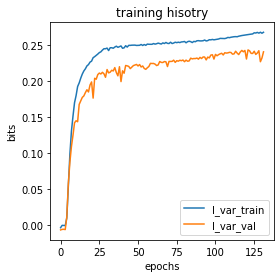

In [19]:
# Show training history
print('On test data:')

I_var_hist = model.history['I_var']
val_I_var_hist = model.history['val_I_var']

fig, ax = plt.subplots(1,1,figsize=[4,4])
ax.plot(I_var_hist, label='I_var_train')
ax.plot(val_I_var_hist, label='I_var_val')
ax.legend()
ax.set_xlabel('epochs')
ax.set_ylabel('bits')
ax.set_title('training hisotry')

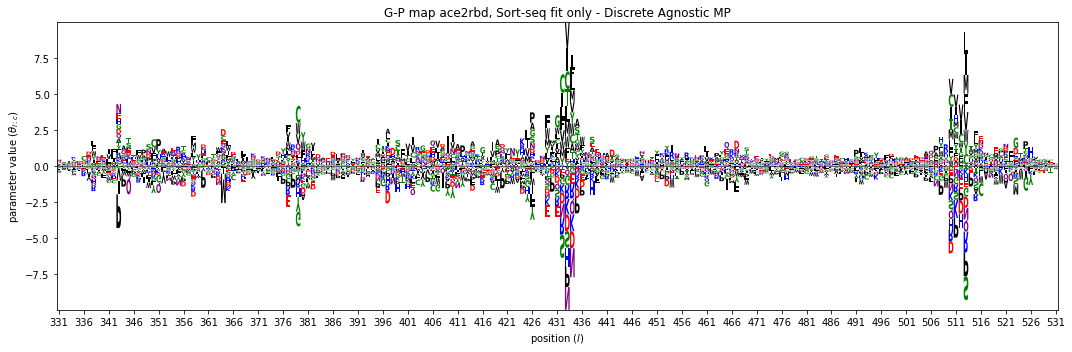

In [20]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(pd.DataFrame(theta,columns=model.alphabet), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel(r'parameter value ($\theta_{l:c}$)')
ax.set_xlabel(r'position ($l$)')
ax.set_title('G-P map ace2rbd, Sort-seq fit only - Discrete Agnostic MP')
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

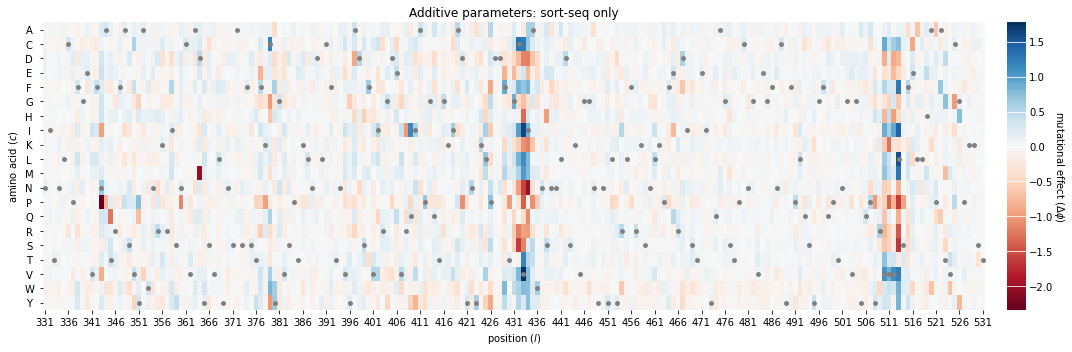

In [15]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=logo.df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [16]:
bloom_single_mut_df = pd.read_csv('single_mut_effects_Bloom.txt')
bloom_single_mut_df.head(10)

,site_RBD,site_SARS2,wildtype,mutant,mutation,mutation_RBD,bind_lib1,bind_lib2,bind_avg,expr_lib1,expr_lib2,expr_avg
0,1,331,N,A,N331A,N1A,-0.05,-0.02,-0.03,-0.14,-0.08,-0.11
1,1,331,N,C,N331C,N1C,-0.08,-0.10,-0.09,-1.56,-0.97,-1.26
2,1,331,N,D,N331D,N1D,0.00,0.07,0.03,-0.75,-0.12,-0.44
3,1,331,N,E,N331E,N1E,0.02,-0.02,0.00,-0.39,-0.24,-0.31
4,1,331,N,F,N331F,N1F,-0.03,-0.16,-0.10,-0.83,-0.57,-0.70
5,1,331,N,G,N331G,N1G,-0.06,-0.02,-0.04,-0.21,-0.29,-0.25
6,1,331,N,H,N331H,N1H,0.01,-0.05,-0.02,-0.86,-0.36,-0.61
7,1,331,N,I,N331I,N1I,-0.06,-0.08,-0.07,-1.05,-0.65,-0.85
8,1,331,N,K,N331K,N1K,-0.01,-0.01,-0.01,-0.17,-0.24,-0.20
9,1,331,N,L,N331L,N1L,-0.08,-0.01,-0.05,-0.81,-0.69,-0.75


In [17]:

bloom_exp_df = pd.DataFrame(columns=alphabet)
for site in range(1,201+1,):

    temp_df = bloom_single_mut_df[bloom_single_mut_df['site_RBD']==site].copy()
    temp_df['expr_lib1']
    bloom_exp_df.loc[site-1] = temp_df['expr_lib1'].values[0:20]




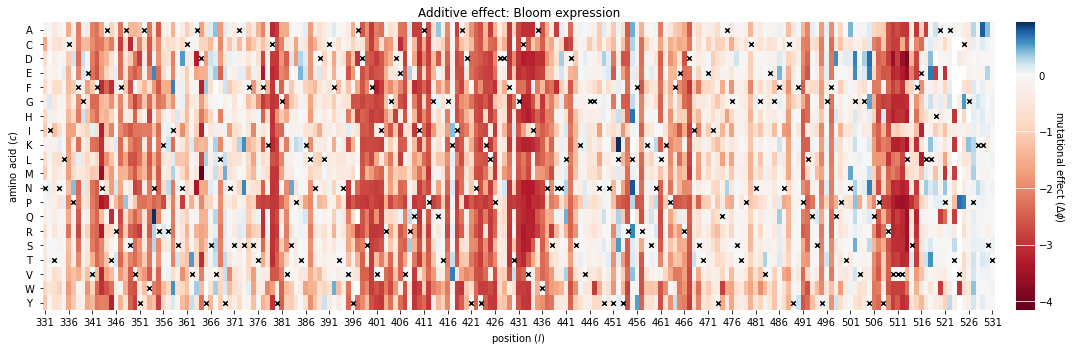

In [18]:
bloom_exp_df
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=bloom_exp_df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'black', 's':20,'marker':'x'},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive effect: Bloom expression')

heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

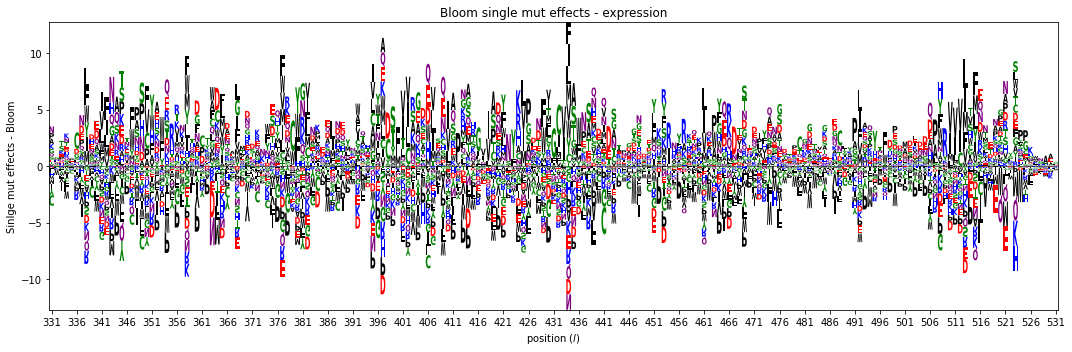

In [21]:
# Get G-P map parameters in matrix form
theta = np.squeeze(gpmap.weights[1].numpy())

# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
#measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)

# Create figure with two panels
fig, axs = plt.subplots(1,1,figsize=[15,5])

# Left panel: draw logo using logomaker
ax = axs
logo = logomaker.Logo(bloom_exp_df.fillna(0), ax=ax,center_values=True, color_scheme='chemistry')
ax.set_ylabel('Sinlge mut effects - Bloom')
ax.set_xlabel(r'position ($l$)')
ax.set_title('Bloom single mut effects - expression')
ax.set_xticks(np.arange(0,201,5))
ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Right panel: draw measurement process as heatmap
# ax = axs[1]
# im = ax.imshow(measurement_process,
#                cmap='Greens',
#                extent=phi_lim+y_lim,
#                vmin=0,
#                origin='lower',
#                interpolation='nearest',
#                aspect="auto")
# ax.set_yticks(y_all)
# ax.set_ylabel('bin number (y)')
# ax.set_xlabel('latent phenotype ($\phi$)')
# ax.set_title('measurement process')
# cb = plt.colorbar(im)
# cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")

# Fix up plot
fig.tight_layout()
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only.png',dpi=300,bbox_inches='tight')
plt.show()

In [22]:
theta

array([[-0.00682158, -0.15885578,  0.01395807, ..., -0.10787638,
        -0.16863151, -0.11750692],
       [ 0.00687243,  0.02881093,  0.0710974 , ...,  0.10487054,
        -0.02082165,  0.02799435],
       [-0.1549221 , -0.25945887, -0.16927795, ..., -0.17742977,
        -0.2682724 , -0.20809881],
       ...,
       [-0.02112772, -0.00501986, -0.16888559, ..., -0.15212324,
        -0.16742706, -0.03445056],
       [-0.00813994,  0.08461318, -0.001215  , ...,  0.01944061,
        -0.03090869,  0.00557108],
       [ 0.08000363,  0.05479366,  0.10462692, ...,  0.02280355,
         0.03264352,  0.03604735]], dtype=float32)

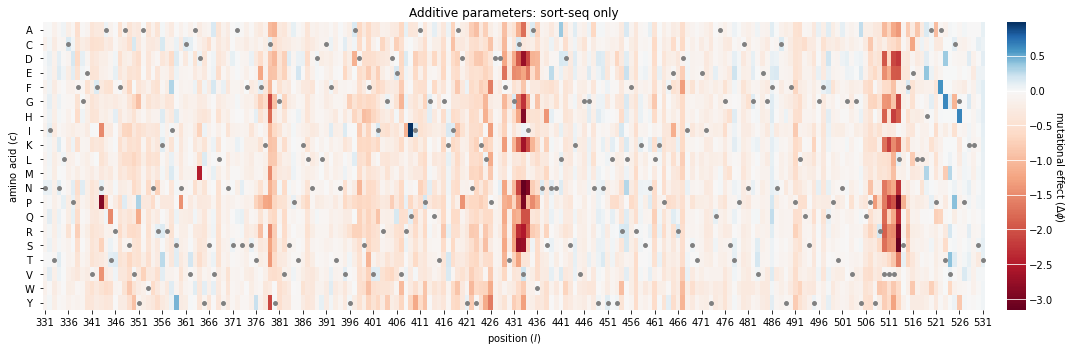

In [23]:
# Create figure
fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters: sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

In [24]:
theta_raw_df = pd.DataFrame(np.squeeze(gpmap.weights[1].numpy()),columns=alphabet)
theta_raw_df

,A,C,D,E,F,G,H,I,K,L,M,N,P,Q,R,S,T,V,W,Y
0,-0.006822,-0.158856,0.013958,-0.002281,-0.126838,-0.071337,-0.070159,-0.146268,-0.042255,-0.101213,-0.076613,0.066310,-0.069145,-0.076446,-0.103838,-0.076408,-0.022405,-0.107876,-0.168632,-0.117507
1,0.006872,0.028811,0.071097,0.051403,0.039771,0.089086,0.060489,0.086754,0.038058,0.032614,0.029470,0.075500,0.011573,0.103966,0.030093,0.054100,0.008624,0.104871,-0.020822,0.027994
2,-0.154922,-0.259459,-0.169278,-0.180474,-0.265652,-0.193049,-0.213915,-0.293654,-0.169164,-0.226808,-0.230492,-0.195239,-0.194419,-0.207982,-0.215537,-0.153734,-0.070682,-0.177430,-0.268272,-0.208099
3,-0.032910,-0.053063,0.094637,0.124394,-0.050554,0.059739,0.026816,-0.033829,0.137540,-0.096430,0.004060,0.108078,-0.061822,0.065190,0.040405,0.020061,0.108979,0.056012,-0.118234,-0.031461
4,0.045595,-0.086931,-0.048616,0.042396,-0.016738,-0.034496,-0.035180,-0.098939,-0.020734,0.030786,-0.015740,-0.018578,0.083089,-0.022598,-0.071592,-0.057929,-0.015026,0.006256,-0.009519,-0.053152
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
196,0.023502,-0.165627,-0.086436,0.004237,-0.263465,-0.024570,-0.011536,-0.108186,0.004621,0.036214,0.035049,0.023214,-0.044609,-0.096688,-0.055418,0.005339,0.024234,0.143890,-0.072558,0.021363
197,-0.018564,-0.070352,0.117411,-0.045961,-0.043850,0.149341,0.005187,0.036340,0.040967,-0.028914,0.020634,0.085785,0.033592,0.000788,0.102794,0.035114,0.083675,0.044208,-0.013980,-0.005198
198,-0.021128,-0.005020,-0.168886,-0.287454,-0.160873,-0.135958,-0.095843,-0.094913,-0.103151,-0.150066,-0.183134,-0.093405,-0.054836,-0.068176,-0.092298,-0.113807,-0.143249,-0.152123,-0.167427,-0.034451
199,-0.008140,0.084613,-0.001215,0.048756,0.056393,-0.006785,0.040453,0.006127,-0.050546,0.006711,0.023157,0.013695,0.034194,-0.018884,-0.052605,0.035861,-0.318562,0.019441,-0.030909,0.005571


In [25]:
# del bloom_exp_df['*']
# del theta_raw_df['*']

Text(0, 0.5, 'MAVE-NN2, G-P map')

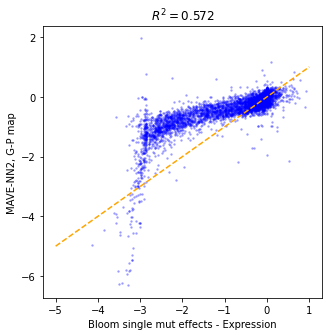

In [29]:
plt.figure(figsize=(5,5))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_raw_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values, 2*theta_raw_df.values,s=2.5,alpha=0.25,color='blue')

lims = [-5,1]
plt.plot(lims,lims,'--',color='orange')
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'$R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')

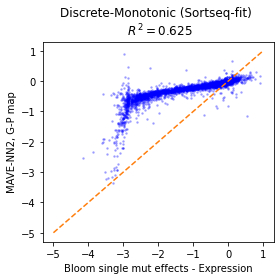

In [30]:
theta_lc = gpmap.get_theta(model,gauge='consensus')['theta_lc']
theta_lc_consensus_df = pd.DataFrame(theta_lc,columns=alphabet)

plt.figure(figsize=(4,4))
Rsq = np.corrcoef(bloom_exp_df.fillna(0).values.ravel(),theta_lc_consensus_df.fillna(0).values.ravel())[0,1]**2
#Rsq = np.corrcoef(bloom_exp_df.values, logo.df.values)[0,1]**2
#plt.scatter(theta_raw_df.values, -logo.df.values,s=5,alpha=0.25,color='red')
plt.scatter(bloom_exp_df.values.ravel(), theta_lc_consensus_df.values.ravel(),s=2.5,alpha=0.25,color='blue')

lims = [-5,1]
plt.plot(lims,lims,'--',color='C1')
plt.xlabel('Bloom single mut effects - Expression')
plt.title(f'Discrete-Monotonic (Sortseq-fit) \n $R^2 = {Rsq:.3f}$')
plt.ylabel('MAVE-NN2, G-P map')
plt.tight_layout()
#plt.savefig('mavenn_bloom_expression_comparison.png',dpi=200,bbox_inches='tight')

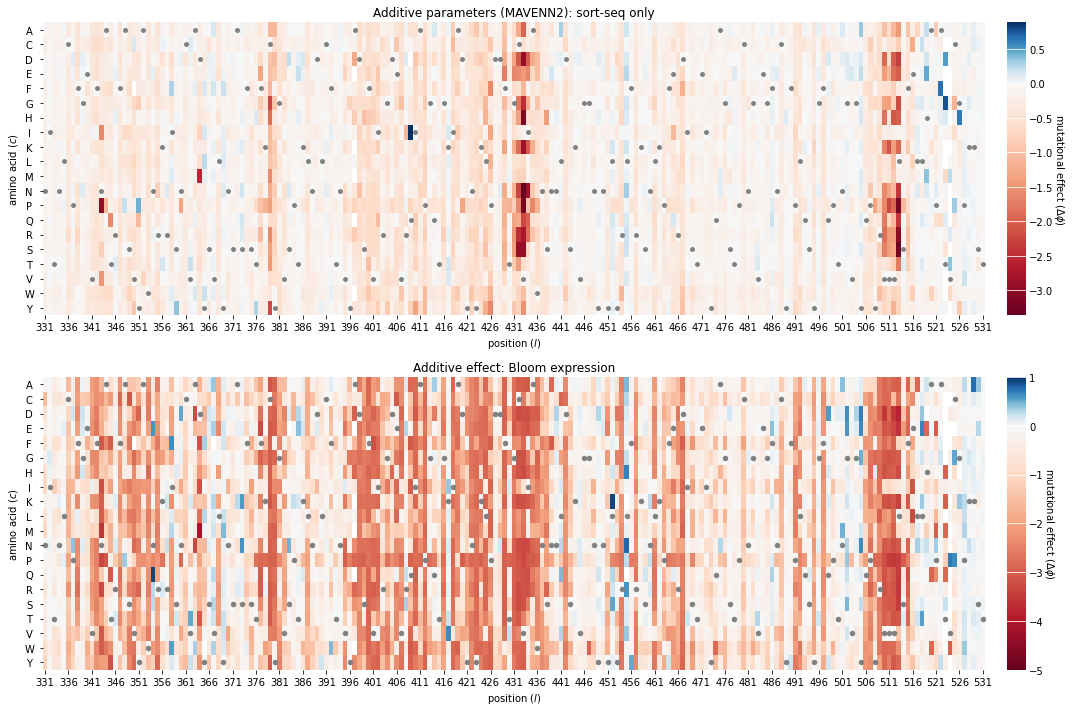

In [31]:

# Create figure
fig, axs = plt.subplots(2,1, figsize=(15,10))

# Draw heatmap
ax = axs[0]

heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=theta_lc,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':15},
                                cmap='RdBu',
                                cbar=True,
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive parameters (MAVENN2): sort-seq only')
heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
#fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_mpa_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

bloom_exp_df
# Create figure
#fig, ax = plt.subplots(1,1, figsize=(15,5))

# Draw heatmap
ax = axs[1]

heatmap_ax, cb = mavenn.heatmap(ax=ax,
                                values=bloom_exp_df.values,
                                alphabet=alphabet,
                                seq=model.x_stats['consensus_seq'],
                                seq_kwargs={'c':'gray', 's':20,'marker':'o'},
                                cmap='RdBu',
                                cbar=True,
                                clim = [-5,1],
                                cmap_size='2%',
                                cmap_pad=.3,
                                ccenter=0)
# Style heatmap (can be different between two dataset)
#heatmap_ax.set_xticks()
heatmap_ax.tick_params(axis='y', which='major', pad=10)
heatmap_ax.set_xlabel('position ($l$)')
heatmap_ax.set_ylabel('amino acid ($c$)')
heatmap_ax.set_title(f'Additive effect: Bloom expression')

heatmap_ax.set_xticks(np.arange(0,201,5))
heatmap_ax.set_xticklabels([f'{x}' for x in range(331,531+1,5)])

# Style colorbar
cb.outline.set_visible(False)
cb.ax.tick_params(direction='in', size=20, color='white')
cb.set_label('mutational effect ($\Delta \phi$)', labelpad=5, rotation=-90, ha='center', va='center')

# Adjust figure and show
fig.tight_layout(w_pad=5)
#fig.savefig('ace2rbd_g-p_map_discrete_monotonic_sortseq_only_heatmap.png',dpi=300,bbox_inches='tight')

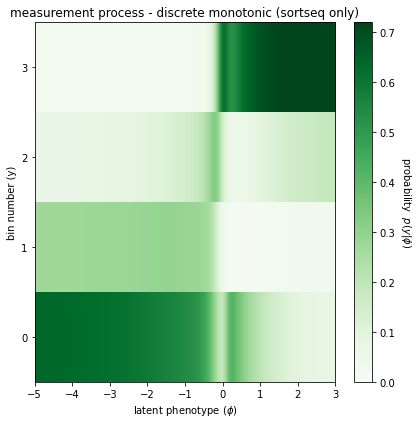

In [32]:
# Create grid in phi space
phi_lim = [-5, 3]
phi_grid = np.linspace(phi_lim[0], phi_lim[1], 1000)

# Create array of allowable y values
Y = mp_mpa.Y    # Y = number of bins
y_lim = [-.5, Y-.5]
y_all = range(Y)

# Compute matrix of p(y|phi) values
measurement_process = mp_mpa.p_of_y_given_phi(y_all, phi_grid)


# Create figure with two panels
fig, ax = plt.subplots(1,1,figsize=[6,6])

# Right panel: draw measurement process as heatmap
im = ax.imshow(measurement_process,
               cmap='Greens',
               extent=phi_lim+y_lim,
               vmin=0,
               origin='lower',
               interpolation='nearest',
               aspect="auto")
ax.set_yticks(y_all)
ax.set_ylabel('bin number (y)')
ax.set_xlabel('latent phenotype ($\phi$)')
ax.set_title('measurement process - discrete monotonic (sortseq only)')
cb = plt.colorbar(im)
cb.set_label('probability  $p(y|\phi)$', rotation=-90, va="bottom")
fig.tight_layout()
#fig.savefig('ace2rbd_mpa_measurment_prcoess_sortseq_only.png',dpi=300,bbox_inches='tight')


In [33]:
#np.save('sortseq_gpmap_monotonic_agnostic',logo.df.values.ravel())
#np.save('sortseq_gpmap_discrete_agnostic',theta.ravel())

In [34]:
# np.save('sortseq_gpmap_agnostic_consensus',
#         gpmap.get_theta(model,gauge='consensus')['theta_lc'].ravel())